# 실행

## 환경세팅

In [ ]:
from keras.initializers import HeUniform
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np
from PIL import Image
import cv2

import pandas as pd

from glob import glob
import tensorflow as tf
import pandas as pd
import random 
import cv2
from os.path import exists
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.layers import *
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB3, preprocess_input

## 데이터 불러오기

In [ ]:
def blur(img):
    return (cv2.blur(img,(5,5)))

In [ ]:
img_gen = ImageDataGenerator(rescale=1./255,preprocessing_function= blur)

In [ ]:
base_model = EfficientNetB0(weights = 'imagenet',include_top=False,input_shape=(224,224,3))

In [ ]:
pwd

'/home/lab16/cnn/Modeling/ENB0'

In [ ]:
train_loader = img_gen.flow_from_directory(directory='/home/lab16/cnn/dataset/train/crop',target_size=(224,224),batch_size=64,seed=42)
test_loader = img_gen.flow_from_directory(directory='/home/lab16/cnn/dataset/valid/crop',target_size=(224,224),batch_size=64,seed=42)

idx_to_classes={val:key for key, val in train_loader.class_indices.items()}
idx_to_classes

Found 2274 images belonging to 2 classes.
Found 562 images belonging to 2 classes.


{0: 'with-leash', 1: 'with-leash-crop'}

## ENB0

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':50,
    'BATCH_SIZE':64,
    'SEED':42
}

In [ ]:
# 모델 설계 (efficientnetb0)
inputs = Input(shape = (CFG['IMG_SIZE'], CFG['IMG_SIZE'], 3))
base=EfficientNetB0(weights='imagenet', include_top=False,input_shape=(224,224,3))

for layer in base.layers :
    layer.trainable=False

last_layer = base.get_layer(base_model.layers[-1].name)
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.4, seed=CFG['SEED'])(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

model = models.Model(base.input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [ ]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=3, min_lr=1e-06)

checkpointer =tf.keras.callbacks.ModelCheckpoint(filepath='checkpointer/0209.hdf5',verbose=1,save_best_only = True)

In [ ]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=['acc'])

In [ ]:
# 모델 피팅
hist=model.fit(train_loader,
                  validation_data=test_loader,    
                  verbose =1,
                  epochs=CFG['EPOCHS'], 
                  callbacks=[early_stopping, reduce_lr,checkpointer])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 0.6950 - acc: 0.5136
Epoch 00001: val_loss improved from inf to 0.69144, saving model to checkpointer/0209.hdf5


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 25s 522ms/step - loss: 0.6950 - acc: 0.5136 - val_loss: 0.6914 - val_acc: 0.5374 - lr: 1.0000e-04
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.6911 - acc: 0.5312
Epoch 00002: val_loss improved from 0.69144 to 0.69113, saving model to checkpointer/0209.hdf5
36/36 [==============================] - 17s 458ms/step - loss: 0.6911 - acc: 0.5312 - val_loss: 0.6911 - val_acc: 0.5374 - lr: 1.0000e-04
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 0.6911 - acc: 0.5352
Epoch 00003: val_loss improved from 0.69113 to 0.69071, saving model to checkpointer/0209.hdf5
36/36 [==============================] - 16s 450ms/step - loss: 0.6911 - acc: 0.5352 - val_loss: 0.6907 - val_acc: 0.5374 - lr: 1.0000e-04
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 0.6925 - acc: 0.5158
Epoch 00004: val_loss did not improve from 0.69071
36/36 [==============================] - 16s 446ms/step - loss: 0.6925 - ac

In [ ]:
# 모델 저장
model.save("0209_ENB0_model_yolo", include_optimizer=False)

INFO:tensorflow:Assets written to: 0209_ENB0_model_yolo/assets


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


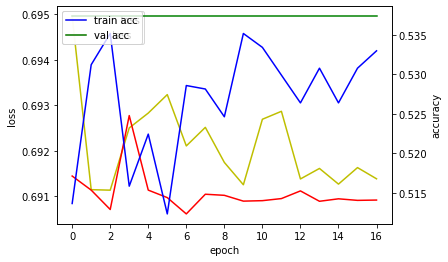

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()